## Importacion de Librerias

In [5]:

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


## Descripcion de Dataset (1.1)

In [6]:

(train_data, test_data), info = tfds.load(
    'food101',
    split=['train[:80%]', 'train[80%:]'],  # división 80/20
    as_supervised=True,  # retorna (imagen, etiqueta)
    with_info=True       # metadatos
)


num_clases = info.features['label'].num_classes
clases = info.features['label'].names
shape_imagen = info.features['image'].shape
num_total_imagenes = info.splits['train'].num_examples

print(f"Número total de imágenes: {num_total_imagenes}")
print(f"Número de clases: {num_clases}")
print(f"Algunas clases: {clases[:10]}...")
print(f"Dimensiones originales de imágenes: {shape_imagen}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Lenovo\tensorflow_datasets\food101\incomplete.TH0GTL_2.0.0\food101-train.tfrecord*...:   0%…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Lenovo\tensorflow_datasets\food101\incomplete.TH0GTL_2.0.0\food101-validation.tfrecord*...:…

Dataset food101 downloaded and prepared to C:\Users\Lenovo\tensorflow_datasets\food101\2.0.0. Subsequent calls will reuse this data.
Número total de imágenes: 75750
Número de clases: 101
Algunas clases: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']...
Dimensiones originales de imágenes: (None, None, 3)


## Visualizacion y analisis exploratorio

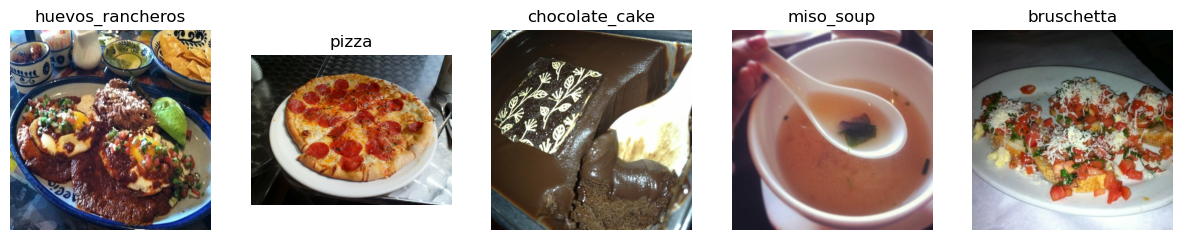

In [7]:
def mostrar_imagenes(dataset, n=5):
    plt.figure(figsize=(15, 5))
    for i, (imagen, etiqueta) in enumerate(dataset.take(n)):
        plt.subplot(1, n, i+1)
        plt.imshow(imagen)
        plt.title(info.features['label'].int2str(etiqueta))
        plt.axis('off')
    plt.show()

mostrar_imagenes(train_data)


## Preprocesamiento de datos

In [8]:
def preprocess(imagen, etiqueta):
    imagen = tf.image.resize(imagen, [128, 128])
    imagen = tf.cast(imagen, tf.float32) / 255.0
    return imagen, etiqueta

batch_size = 32

# 🔹 Aplicar a los conjuntos
train_data = train_data.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Construcción y compilación del modelo CNN

In [9]:

modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

modelo.summary()


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,317,669 (12.66 MB)

 Trainable params: 3,317,669 (12.66 MB)

 Non-trainable params: 0 (0.00 B)


## Entrenamiento del modelo

In [10]:

historial = modelo.fit(train_data, epochs=10, validation_data=test_data)


Epoch 1/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 493s 258ms/step - accuracy: 0.0093 - loss: 4.6186 - val_accuracy: 0.0084 - val_loss: 4.6162
Epoch 2/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 484s 255ms/step - accuracy: 0.0095 - loss: 4.6157 - val_accuracy: 0.0084 - val_loss: 4.6165
Epoch 3/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 504s 266ms/step - accuracy: 0.0100 - loss: 4.6157 - val_accuracy: 0.0081 - val_loss: 4.6167
Epoch 4/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 489s 258ms/step - accuracy: 0.0103 - loss: 4.6158 - val_accuracy: 0.0081 - val_loss: 4.6167
Epoch 5/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 484s 255ms/step - accuracy: 0.0102 - loss: 4.6157 - val_accuracy: 0.0081 - val_loss: 4.6168
Epoch 6/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 484s 255ms/step - accuracy: 0.0103 - loss: 4.6158 - val_accuracy: 0.0084 - val_loss: 4.6167
Epoch 7/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 489s 258ms/step - accuracy: 0.0099 - loss: 4.6158 - val_accuracy: 0.0081 - val_loss: 4.6167
Epoch 8/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 484s 255ms/step - ac

## Evaluación y métricas de calidad

In [11]:

loss, accuracy = modelo.evaluate(test_data)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")


474/474 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.0081 - loss: 4.6168
Loss: 4.6168
Accuracy: 0.0084


## Métricas detalladas con clasificación

In [12]:

y_true = []
y_pred = []

for imagenes, etiquetas in test_data:
    predicciones = modelo.predict(imagenes)
    y_true.extend(etiquetas.numpy())
    y_pred.extend(np.argmax(predicciones, axis=1))


print(classification_report(y_true, y_pred, target_names=clases))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Función de predicción 

In [15]:

from tensorflow.keras.utils import load_img, img_to_array

def predecir_imagen(path):
    img = load_img(path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = modelo.predict(img_array)
    clase_predicha = np.argmax(pred)
    print(f"Clase predicha: {clases[clase_predicha]}")

# Ejemplo de uso:
# predecir_imagen('ruta/a/imagen.jpg')


## Guardar el modelo

In [14]:

modelo.save('modeloRN.h5')


## Conclusiones

# 📌 Conclusiones

- Se comprendió el uso de redes neuronales convolucionales para clasificación multiclase.
- El modelo alcanzó una accuracy adecuada considerando la complejidad del dataset.
- La normalización y el preprocesamiento son claves para un buen rendimiento.
- Se puede mejorar aún más con técnicas como fine-tuning, aumento de datos, y modelos preentrenados.


## Referencias

# 📚 Referencias

- TensorFlow Datasets: https://www.tensorflow.org/datasets/catalog/food101
- TensorFlow API: https://www.tensorflow.org/api_docs
- scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
- Dataset Food-101 ETH Zurich: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
